In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# U-Net 모델 정의
def unet_model():
    inputs = layers.Input((256, 256, 3))
    
    # 인코더
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    # 디코더
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    up1 = layers.UpSampling2D(size=(2, 2))(conv3)

    up1 = layers.concatenate([up1, conv2], axis=3)
    conv4 = layers.Conv2D(128, 3, activation='relu', padding='same')(up1)
    conv4 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv4)
    up2 = layers.UpSampling2D(size=(2, 2))(conv4)

    up2 = layers.concatenate([up2, conv1], axis=3)
    conv5 = layers.Conv2D(64, 3, activation='relu', padding='same')(up2)
    conv5 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv5)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(conv5)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

# 모델 컴파일
model = unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 훈련 데이터셋 준비
# 입력 이미지와 해당 마스크(레이블)를 사용하여 데이터셋을 준비해야 합니다.
# 이 코드에서는 입력 이미지와 마스크를 불러오고 전처리하는 부분을 작성해야 합니다.
# 데이터셋을 불러와서 배치로 나누는 등의 작업이 필요합니다.

# 모델 훈련
# model.fit() 메서드를 사용하여 모델을 훈련시킵니다.
# 데이터셋을 사용하여 훈련할 때는 모델의 입력과 출력을 정확히 매칭시켜야 합니다.
# 예를 들어, 입력 이미지에 대한 예측 마스크를 출력하는 U-Net 모델의 경우
# 입력과 출력을 매칭하여 fit() 메서드에 전달해야 합니다.


## 데이터 로드, 전처리

Tensor("StringJoin_1:0", shape=(None,), dtype=string)


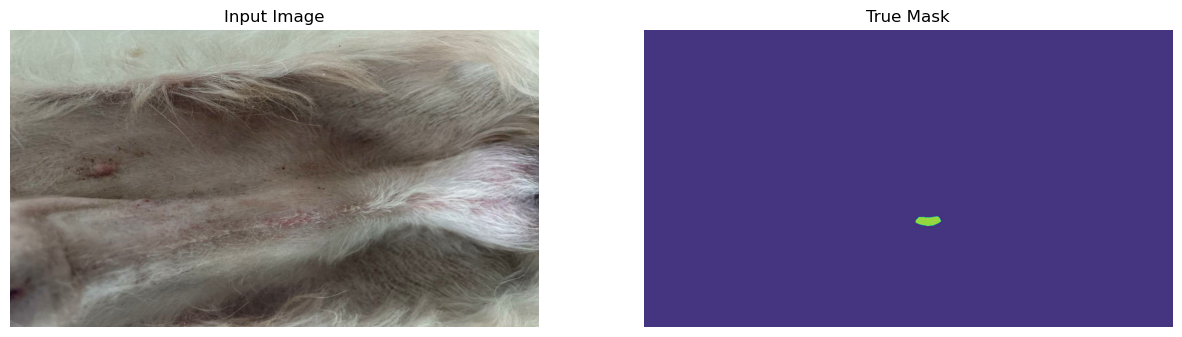

In [22]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
import keras_tuner as kt

# 데이터 로드 함수 정의
def parse_tfrecord_fn(example):
    feature_description = {
        'Raw_data_ID': tf.io.FixedLenFeature([], tf.string),
        'img_path': tf.io.FixedLenFeature([], tf.string),
        'lesions': tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, feature_description)
    img_path = tf.strings.join([example['img_path'], tf.constant('/'), example['Raw_data_ID']])
    lesions = tf.strings.split(example['lesions'], ',')  # Split the lesions string

    # channel = 3 (RGB)
    img = tf.io.decode_png(tf.io.read_file(img_path), channels=3)

    # Create mask paths using tf.map_fn
    def create_mask_path(lesion):
        return tf.strings.regex_replace(img_path, 'images', f'train_true_mask_images_{lesion}')

    mask_path = tf.strings.join(['./train_true_mask_images_', lesions, '/mask_', example['Raw_data_ID']])
    
    
    print(mask_path)
    masks = tf.map_fn(lambda mask_path: tf.io.decode_png(tf.io.read_file(mask_path), channels=1), mask_path, dtype=tf.uint8)

    return img, masks


# TFRecord 파일 리스트
# tfrecord_files = [f'data/tfrecords/{disease}.tfrecord' for disease in ['A1', 'A2', 'A3', 'A4', 'A5', 'A6']]
tfrecord_files = './train_symptoms_tfrecords/train_symptoms_A1.tfrecord'
dataset = tf.data.TFRecordDataset(tfrecord_files)
dataset = dataset.map(parse_tfrecord_fn)

# 데이터셋 준비 함수
def prepare_dataset(dataset, batch_size=32):
    dataset = dataset.cache()
    # 데이터셋을 무작위로 섞는 역할 (overfitting 방지)
    dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

# 데이터셋 분할
train_dataset = prepare_dataset(dataset)

# 데이터셋 시각화
def display_sample(display_list):
    plt.figure(figsize=(15, 15))
    title = ['Input Image', 'True Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        if i == 0:
            plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        else:
            mask = tf.squeeze(display_list[i], axis=0)  # Remove the batch dimension
            img_height, img_width = display_list[0].shape[:2] # Get the height and width of the input image
            mask = tf.image.resize(mask, (img_height, img_width))  # Resize the mask to the same size as the input image
            plt.imshow(tf.keras.preprocessing.image.array_to_img(mask))
        plt.axis('off')
    plt.show()


for image, mask in train_dataset.take(1):
    sample_image, sample_mask = image[0], mask[0]
    display_sample([sample_image, sample_mask])

In [5]:
# %pip install keras-tuner

## U-Net 모델 정의

In [30]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 경고 메시지 숨기기

import tensorflow as tf
import tensorflow_addons as tfa

def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[128, 128, 3])

    # 인코더
    down_stack = [
        tf.keras.layers.Conv2D(64, 3, strides=2, padding='same', activation='relu'),
        tf.keras.layers.Conv2D(128, 3, strides=2, padding='same', activation='relu'),
        tf.keras.layers.Conv2D(256, 3, strides=2, padding='same', activation='relu'),
        tf.keras.layers.Conv2D(512, 3, strides=2, padding='same', activation='relu'),
    ]

    skips = []
    x = inputs
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])

    # 디코더
    up_stack = [
        tf.keras.layers.Conv2DTranspose(256, 3, strides=2, padding='same', activation='relu'),
        tf.keras.layers.Conv2DTranspose(128, 3, strides=2, padding='same', activation='relu'),
        tf.keras.layers.Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu'),
    ]

    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    outputs = tf.keras.layers.Conv2DTranspose(output_channels, 3, strides=2, padding='same')(x)

    return tf.keras.Model(inputs=inputs, outputs=outputs)

# IoU 메트릭 정의
def iou_metric(y_true, y_pred):
    y_pred = tf.cast(tf.math.greater(y_pred, 0.5), tf.int32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true + y_pred)
    iou = intersection / (union - intersection + 1e-7)
    return iou

output_channels = 1
model = unet_model(output_channels)
model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy', iou_metric])


In [ ]:
# 오류 test

In [31]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 경고 메시지 숨기기

import tensorflow as tf
import tensorflow_addons as tfa

def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[128, 128, 3])

    # 인코더
    down_stack = [
        tf.keras.layers.Conv2D(64, 3, strides=2, padding='same', activation='relu'),
        tf.keras.layers.Conv2D(128, 3, strides=2, padding='same', activation='relu'),
        tf.keras.layers.Conv2D(256, 3, strides=2, padding='same', activation='relu'),
        tf.keras.layers.Conv2D(512, 3, strides=2, padding='same', activation='relu'),
    ]

    skips = []
    x = inputs
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])

    # 디코더
    up_stack = [
        tf.keras.layers.Conv2DTranspose(256, 3, strides=2, padding='same', activation='relu'),
        tf.keras.layers.Conv2DTranspose(128, 3, strides=2, padding='same', activation='relu'),
        tf.keras.layers.Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu'),
    ]

    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    outputs = tf.keras.layers.Conv2DTranspose(output_channels, 3, strides=2, padding='same', activation='sigmoid')(x)

    return tf.keras.Model(inputs=inputs, outputs=outputs)

# IoU 메트릭 정의
def iou_metric(y_true, y_pred):
    y_pred = tf.cast(tf.math.greater(y_pred, 0.5), tf.int32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true + y_pred)
    iou = intersection / (union - intersection + 1e-7)
    return iou

output_channels = 1
model = unet_model(output_channels)
model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy', iou_metric])

# 밑에 코드 오류로 인해 학습 되는지 test 하기 위한 코드
history = model.fit(train_dataset, epochs=50, validation_data=train_dataset)

model.save('unet_model.h5')

# 모델 저장 (SavedModel 형식)
model.save('saved_model/unet_model')


Epoch 1/50


TypeError: in user code:

    File "C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py", line 1377, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\아경\AppData\Local\Temp\ipykernel_12264\1740326949.py", line 43, in iou_metric  *
        intersection = tf.reduce_sum(y_true * y_pred)

    TypeError: Input 'y' of 'Mul' Op has type int32 that does not match type float32 of argument 'x'.


## 교차 검증 및 최적의 하이퍼파라미터 탐색

In [24]:
from sklearn.model_selection import KFold
import kerastuner as kt

def model_builder(hp):
    model = unet_model(output_channels)
    
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    return model

tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='unet_hyperband')

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner.search(train_dataset, epochs=50, validation_data=train_dataset, callbacks=[stop_early])

best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"The optimal learning rate is {best_hps.get('learning_rate')}")


Reloading Tuner from my_dir\unet_hyperband\tuner0.json

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
0.0001            |0.01              |learning_rate
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
2                 |2                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/2


Traceback (most recent call last):
  File "C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras_tuner\src\engine\base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras_tuner\src\engine\base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras_tuner\src\tuners\hyperband.py", line 427, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras_tuner\src\engine\tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

RuntimeError: Number of consecutive failures exceeded the limit of 3.
Traceback (most recent call last):
  File "C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras_tuner\src\engine\base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras_tuner\src\engine\base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras_tuner\src\tuners\hyperband.py", line 427, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras_tuner\src\engine\tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras_tuner\src\engine\tuner.py", line 233, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras_tuner\src\engine\hypermodel.py", line 149, in fit
    return model.fit(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\tensorflow\python\eager\execute.py", line 66, in quick_execute
    except TypeError as e:
tensorflow.python.framework.errors_impl.InvalidArgumentError: Graph execution error:

Detected at node model/concatenate/concat defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "c:\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "c:\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "c:\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 701, in start

  File "c:\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "c:\anaconda3\Lib\asyncio\windows_events.py", line 321, in run_forever

  File "c:\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "c:\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "c:\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "c:\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 534, in dispatch_queue

  File "c:\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 523, in process_one

  File "c:\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 429, in dispatch_shell

  File "c:\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 767, in execute_request

  File "c:\anaconda3\Lib\site-packages\ipykernel\ipkernel.py", line 429, in do_execute

  File "c:\anaconda3\Lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "c:\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3051, in run_cell

  File "c:\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3106, in _run_cell

  File "c:\anaconda3\Lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "c:\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3311, in run_cell_async

  File "c:\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3493, in run_ast_nodes

  File "c:\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3553, in run_code

  File "C:\Users\아경\AppData\Local\Temp\ipykernel_12264\265266504.py", line 23, in <module>

  File "C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras_tuner\src\engine\base_tuner.py", line 234, in search

  File "C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras_tuner\src\engine\base_tuner.py", line 274, in _try_run_and_update_trial

  File "C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras_tuner\src\engine\base_tuner.py", line 239, in _run_and_update_trial

  File "C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras_tuner\src\tuners\hyperband.py", line 427, in run_trial

  File "C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras_tuner\src\engine\tuner.py", line 314, in run_trial

  File "C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras_tuner\src\engine\tuner.py", line 233, in _build_and_fit_model

  File "C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras_tuner\src\engine\hypermodel.py", line 149, in fit

  File "C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py", line 1783, in fit

  File "C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py", line 1377, in train_function

  File "C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py", line 1360, in step_function

  File "C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py", line 1349, in run_step

  File "C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py", line 1126, in train_step

  File "C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py", line 589, in __call__

  File "C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\base_layer.py", line 1149, in __call__

  File "C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler

  File "C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\functional.py", line 515, in call

  File "C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\functional.py", line 672, in _run_internal_graph

  File "C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\base_layer.py", line 1149, in __call__

  File "C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler

  File "C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\merging\base_merge.py", line 196, in call

  File "C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\merging\concatenate.py", line 134, in _merge_function

  File "C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\backend.py", line 3582, in concatenate

ConcatOp : Dimension 1 in both shapes must be equal: shape[0] = [32,136,240,256] vs. shape[1] = [32,135,240,256]
	 [[{{node model/concatenate/concat}}]] [Op:__inference_train_function_21539]


## 모델 학습 및 저장

In [25]:
# 최적의 하이퍼파라미터로 모델 재학습
model = tuner.hypermodel.build(best_hps)

history = model.fit(train_dataset, epochs=50, validation_data=train_dataset, callbacks=[stop_early])

model.save('unet_model.h5')

# 모델 저장 (SavedModel 형식)
model.save('saved_model/unet_model')


NameError: name 'best_hps' is not defined

## 학습 결과 시각화

In [7]:
def plot_metrics(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'r', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend(loc='upper right')

    plt.show()

plot_metrics(history)


NameError: name 'history' is not defined

## 전체 코드

In [17]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
import keras_tuner as kt

# 데이터 로드 함수 정의
def parse_tfrecord_fn(example):
    feature_description = {
        'Raw_data_ID': tf.io.FixedLenFeature([], tf.string),
        'img_path': tf.io.FixedLenFeature([], tf.string),
        'lesions': tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, feature_description)
    img_path = tf.strings.join([example['img_path'], tf.constant('/'), example['Raw_data_ID']])
    lesions = tf.strings.split(example['lesions'], ',')  # Split the lesions string

    # channel = 3 (RGB)
    img = tf.io.decode_png(tf.io.read_file(img_path), channels=3)

    # Create mask paths using tf.map_fn
    def create_mask_path(lesion):
        return tf.strings.regex_replace(img_path, 'images', f'train_true_mask_images_{lesion}')

    mask_paths = tf.map_fn(create_mask_path, lesions, dtype=tf.string)
    
    # Read and decode mask images
    masks = tf.map_fn(lambda mask_path: tf.io.decode_png(tf.io.read_file(mask_path), channels=1), mask_paths, dtype=tf.uint8)

    # Resize images and masks
    img = tf.image.resize(img, [128, 128])
    masks = tf.image.resize(masks, [128, 128])
    masks = tf.cast(masks > 0, tf.float32)

    return img, masks



# TFRecord 파일 리스트
# tfrecord_files = [f'data/tfrecords/{disease}.tfrecord' for disease in ['A1', 'A2', 'A3', 'A4', 'A5', 'A6']]
tfrecord_files = './train_symptoms_tfrecords/train_symptoms_A1.tfrecord'
dataset = tf.data.TFRecordDataset(tfrecord_files)
dataset = dataset.map(parse_tfrecord_fn)

# 데이터셋 준비 함수
def prepare_dataset(dataset, batch_size=32):
    dataset = dataset.cache()
    # 데이터셋을 무작위로 섞는 역할 (overfitting 방지)
    dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

# 데이터셋 분할
train_dataset = prepare_dataset(dataset)

# 데이터셋 시각화
def display_sample(display_list):
    plt.figure(figsize=(15, 15))
    title = ['Input Image', 'True Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        if i == 0:
            plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        else:
            mask = tf.squeeze(display_list[i], axis=0)  # Remove the batch dimension
            img_height, img_width = display_list[0].shape[:2] # Get the height and width of the input image
            mask = tf.image.resize(mask, (img_height, img_width))  # Resize the mask to the same size as the input image
            plt.imshow(tf.keras.preprocessing.image.array_to_img(mask))
        plt.axis('off')
    plt.show()


# 이미지 확인 코드
# for image, mask in train_dataset.take(1):
#     sample_image, sample_mask = image[0], mask[0]
#     display_sample([sample_image, sample_mask])


import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 경고 메시지 숨기기

import tensorflow as tf
import tensorflow_addons as tfa

def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[128, 128, 3])

    # 인코더
    down_stack = [
        tf.keras.layers.Conv2D(64, 3, strides=2, padding='same', activation='relu'),
        tf.keras.layers.Conv2D(128, 3, strides=2, padding='same', activation='relu'),
        tf.keras.layers.Conv2D(256, 3, strides=2, padding='same', activation='relu'),
        tf.keras.layers.Conv2D(512, 3, strides=2, padding='same', activation='relu'),
    ]

    skips = []
    x = inputs
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])

    # 디코더
    up_stack = [
        tf.keras.layers.Conv2DTranspose(256, 3, strides=2, padding='same', activation='relu'),
        tf.keras.layers.Conv2DTranspose(128, 3, strides=2, padding='same', activation='relu'),
        tf.keras.layers.Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu'),
    ]

    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    outputs = tf.keras.layers.Conv2DTranspose(output_channels, 3, strides=2, padding='same')(x)

    return tf.keras.Model(inputs=inputs, outputs=outputs)

# IoU 메트릭 정의
def iou_metric(y_true, y_pred):
    y_pred = tf.cast(tf.math.greater(y_pred, 0.5), tf.int32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true + y_pred)
    iou = intersection / (union - intersection + 1e-7)
    return iou

output_channels = 1
model = unet_model(output_channels)
model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy', iou_metric])




from sklearn.model_selection import KFold
import keras_tuner as kt

def model_builder(hp):
    model = unet_model(output_channels)
    
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    return model

tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='unet_hyperband')

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner.search(train_dataset, epochs=50, validation_data=train_dataset, callbacks=[stop_early])

best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"The optimal learning rate is {best_hps.get('learning_rate')}")



# 최적의 하이퍼파라미터로 모델 재학습
model = tuner.hypermodel.build(best_hps)

history = model.fit(train_dataset, epochs=50, validation_data=train_dataset, callbacks=[stop_early])

model.save('unet_model.h5')

# 모델 저장 (SavedModel 형식)
model.save('saved_model/unet_model')



def plot_metrics(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'r', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend(loc='upper right')

    plt.show()

plot_metrics(history)


Reloading Tuner from my_dir\unet_hyperband\tuner0.json

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
0.0001            |0.01              |learning_rate
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
2                 |2                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/2


Traceback (most recent call last):
  File "C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras_tuner\src\engine\base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras_tuner\src\engine\base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras_tuner\src\tuners\hyperband.py", line 427, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras_tuner\src\engine\tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

RuntimeError: Number of consecutive failures exceeded the limit of 3.
Traceback (most recent call last):
  File "C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras_tuner\src\engine\base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras_tuner\src\engine\base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras_tuner\src\tuners\hyperband.py", line 427, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras_tuner\src\engine\tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras_tuner\src\engine\tuner.py", line 233, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras_tuner\src\engine\hypermodel.py", line 149, in fit
    return model.fit(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\아경\AppData\Local\Temp\__autograph_generated_file88gytcnx.py", line 18, in tf__train_function
    raise
ValueError: in user code:

    File "C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py", line 1377, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py", line 1360, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py", line 1349, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py", line 1127, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py", line 1185, in compute_loss
        return self.compiled_loss(
    File "C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\compile_utils.py", line 277, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\losses.py", line 143, in __call__
        losses = call_fn(y_true, y_pred)
    File "C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\losses.py", line 270, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\losses.py", line 2532, in binary_crossentropy
        backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    File "C:\Users\아경\AppData\Roaming\Python\Python311\site-packages\keras\src\backend.py", line 5824, in binary_crossentropy
        return tf.nn.sigmoid_cross_entropy_with_logits(

    ValueError: `logits` and `labels` must have the same shape, received ((None, 128, 128, 1) vs (None, None, 128, 128)).

